# Investigating Cancer Genomics: Mutation Patterns and Patient Outcomes

Cancer is a disease of the genome, and every cancer originates from a series of **mutations in DNA** causing cells to grow uncontrollably. But not all cancers are the same — and neither are the mutations that drive them.

In this notebook, you will explore real breast cancer patient data to understand how different gene mutations relate to cancer subtypes and patient outcomes. You’ll investigate questions like:

- Which gene mutations are most common in breast cancer?
- How do mutation rates vary across molecular subtypes
- Are certain mutations associated with more aggressive disease or lower survival?
- Do mutations correlate with how patients are treated (e.g., chemotherapy)?

Understanding these patterns can help doctors better **stratify risk**, **choose therapies**, and even **design new treatments**.

---

In [1]:
import pandas as pd
from utils import *
from mut_widget import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## The METABRIC Dataset: 

We'll be using real patient data from the **METABRIC (Molecular Taxonomy of Breast Cancer International Consortium)** study. We found this dataset on [Kaggle](https://www.kaggle.com/), a widely-used, data-driven platform that hosts thousands of high-quality datasets. The link to our dataset can be accessed [here!](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric)

An excerpt from the dataset’s Kaggle description provides a detailed overview of the data and its context.

"*The Molecular Taxonomy of Breast Cancer International Consortium (METABRIC) database is a Canada-UK Project which contains targeted sequencing data of 1,980 primary breast cancer samples. Clinical and genomic data was downloaded from cBioPortal.*

*The dataset was collected by Professor Carlos Caldas from Cambridge Research Institute and Professor Sam Aparicio from the British Columbia Cancer Centre in Canada and published on Nature Communications (Pereira et al., 2016). It was also featured in multiple papers including Nature and others:*

- *[Associations between genomic stratification of breast cancer and centrally reviewed tumor pathology in the METABRIC cohort](https://www.nature.com/articles/s41523-018-0056-8)*
- *[Predicting Outcomes of Hormone and Chemotherapy in the Molecular Taxonomy of Breast Cancer International Consortium (METABRIC) Study by Biochemically-inspired Machine Learning](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5461908/)*"


**Important Note**: Every patient in this dataset **already has breast cancer.**  

We'll start by using the [`pandas`](https://pandas.pydata.org/) library. `pandas` is a powerful and widely-used Python tool for working with tabular data. It allows us to read, organize, and manipulate datasets efficiently, especially when dealing with spreadsheets or CSV (Comma Separate Value) files. Let’s load our data using `pandas`:

In [11]:
df = pd.read_csv("METABRIC.csv")
df.head() 

/var/folders/rk/wdhf611s3h56skfqfbbm_25m0000gn/T/ipykernel_23010/2670141452.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("METABRIC.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [12]:
print(f"There are {len(df.columns)} columns in our dataset!")

There are 693 columns in our dataset!


**Question 0.1** Wow, that’s quite a few columns! Can you think of a reason why this dataset might include so many??

*Type Your Answer Here*

Below we’ll define some of the most relevant columns to focus on, these will be the primary features we use throughout the rest of the notebook. Feel free to reference the Kaggle [dataset](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric) on your own to explore other interesting aspects of the dataset!

In [15]:
# Manually defining important clinical and outcome columns
clinical_columns = [
    'patient_id',
    'age_at_diagnosis',
    'type_of_breast_surgery',
    'cancer_type_detailed',
    'pam50_+_claudin-low_subtype',
    'chemotherapy',
    'hormone_therapy',
    'radio_therapy',
    'tumor_size',
    'tumor_stage',
    'overall_survival',
    'overall_survival_months'
]

# Select all columns that end with '_mut'
mutation_columns = [col for col in df.columns if col.endswith('_mut')]

# Combine the clinical + mutation columns
relevant_columns = clinical_columns + mutation_columns

# Filter the dataframe
filtered_df = df[relevant_columns]

# Display the shape to confirm how much we reduced it
print("Filtered Dataframe shape:", filtered_df.shape[0], "rows and", filtered_df.shape[1], "columns")
filtered_df.head()

Filtered Dataframe shape: 1904 rows and 185 columns


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type_detailed,pam50_+_claudin-low_subtype,chemotherapy,hormone_therapy,radio_therapy,tumor_size,tumor_stage,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Invasive Ductal Carcinoma,claudin-low,0,1,1,22.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,LumA,0,1,1,10.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Invasive Ductal Carcinoma,LumB,1,1,0,15.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,LumB,1,1,1,25.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,LumB,1,1,1,40.0,2.0,...,0,0,0,0,0,0,0,0,0,0


Python Widgets allow us to build interactive elements such as dropdowns, sliders, and checkboxes. They’re particularly useful for dynamically visualizing and filtering datasets without having to rewrite your code. 

**Question 0.2.** 
Below, we’ve created a widget for selecting certain columns from our dataset. Use the dropdown menu to choose a column and describe how it relates to a concept we've covered in this course!

In [16]:
# Link dropdown selection to function
dropdown.observe(show_description, names='value')

# Display the widget
display(dropdown, output)

Dropdown(description='Column:', layout=Layout(width='60%'), options=('patient_id', 'age_at_diagnosis', 'type_o…

Output()

*Type Your Answer Here*

## Section 1: Frequency

Imagine for a second you're a doctor, or some kind of biomedical researcher, trying to understand the genetic factors behind breast cancer. One of your goals might be to identify which genes are most commonly mutated among patients, as this information can guide diagnoses, help risk assessment, or even formulate treatment strategies.

In our dataset, we’ve **modified** the mutation data to make it easier to analyze. For each breast cancer patient, *every gene is represented using binary values*:

- 0 – The patient does not have a mutation in that gene

- 1 – The patient has at least one type of mutation in that gene

For example, if a patient has **any kind** of mutation in their TP53 gene, but not in BRCA1, their data would show:
- TP53 = 1
- BRCA1 = 0

This simplification allows us to more easily quantify and compare mutation frequencies across the entire patient population.

Run the cell below to generate a bar chart showing the proportion of patients who carry mutations in several key cancer-related genes. Afterward, you'll answer a few questions based on the patterns you observe in the chart.

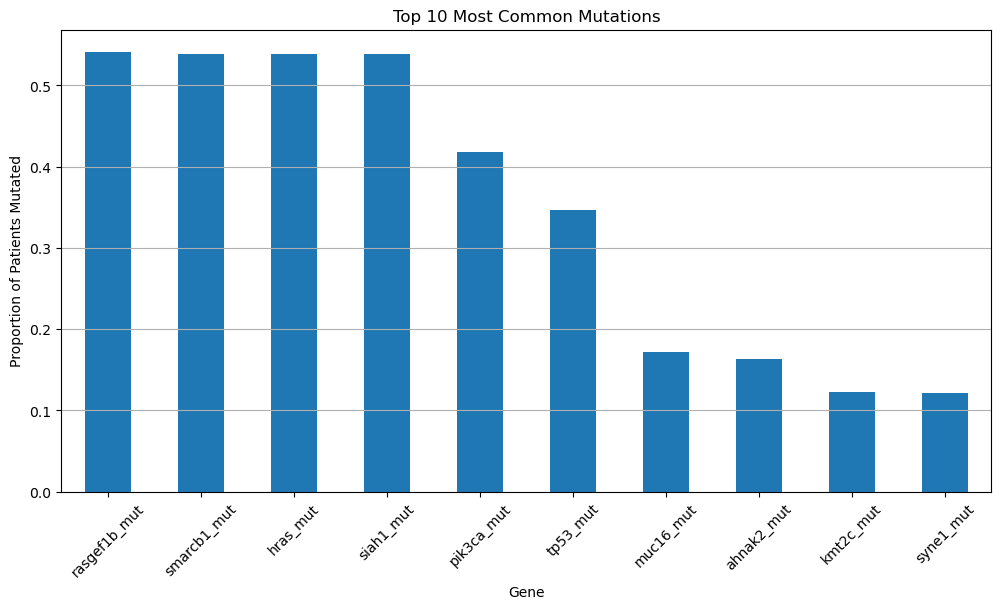

In [17]:
mutation_cols = [col for col in filtered_df.columns if col.endswith('_mut')]

# Create a binary version of mutation columns
binary_mutations = filtered_df[mutation_cols].map(lambda x: 0 if x == "0" else 1)

# Merge back with the clinical columns
clinical_cols = [col for col in filtered_df.columns if col not in mutation_cols]
eda_df = pd.concat([filtered_df[clinical_cols], binary_mutations], axis=1)

# Mutation frequencies
mutation_rates = eda_df[mutation_cols].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
mutation_rates[:10].plot(kind='bar')
plt.title('Top 10 Most Common Mutations')
plt.ylabel('Proportion of Patients Mutated')
plt.xlabel('Gene')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Question 1.1.**  Which six genes have the highest mutation rates in the dataset? How can you tell?

*Type Your Answer in Place of Each Number*

1. 
2. 
3. 
4. 
5. 
6.

*Type Your Justification Here*

**Question 1.2.** Do any of these genes look familiar, based on what we've discussed in class? Explain what you remember about them and why they might be important in the context of cancer.

*Type Your Answer Here*

**Question 1.3.** Choose one of the top six most frequently mutated genes and propose a hypothesis why this gene might be so commonly mutated in breast cancer patients. Why do you think a mutation in this particular gene could be especially indicative of cancer development?

*Type Your Answer Here*

## Section 2: Aggresive

###  Breast Cancer Subtypes and Mutation Patterns

Breast cancer is not a single disease — it includes many **molecular subtypes**. One common classification is called **PAM50**, which includes:

- **Luminal A** – less aggressive, hormone-positive
- **Luminal B** – more aggressive than Luminal A
- **HER2-enriched** – driven by HER2 amplification
- **Basal-like** – most aggressive, often triple-negative
- **Normal-like** – rare, resembles healthy breast tissue

In this section, we’ll see how gene mutations vary across these subtypes.

We’ll begin by looking at **TP53**, which is often referred to as the “*guardian of the genome.*” This gene plays a critical role in regulating cell growth and initiating repair when DNA damage is detected.

When TP53 is mutated, these protective functions become disrupted. Thus, damaged cells can begin to grow and divide unchecked. This loss of control is a hallmark of more aggressive forms of cancer, which is why TP53 mutations are so frequently observed in cancer patients.

We encourage you to learn more about TP53 [here!](https://medlineplus.gov/genetics/gene/tp53/)

#### Bar Charts

Run the cell below. Please do not modify any of the lines—this cell has been pre-written to generate a specific visualization you’ll use to answer the following questions.

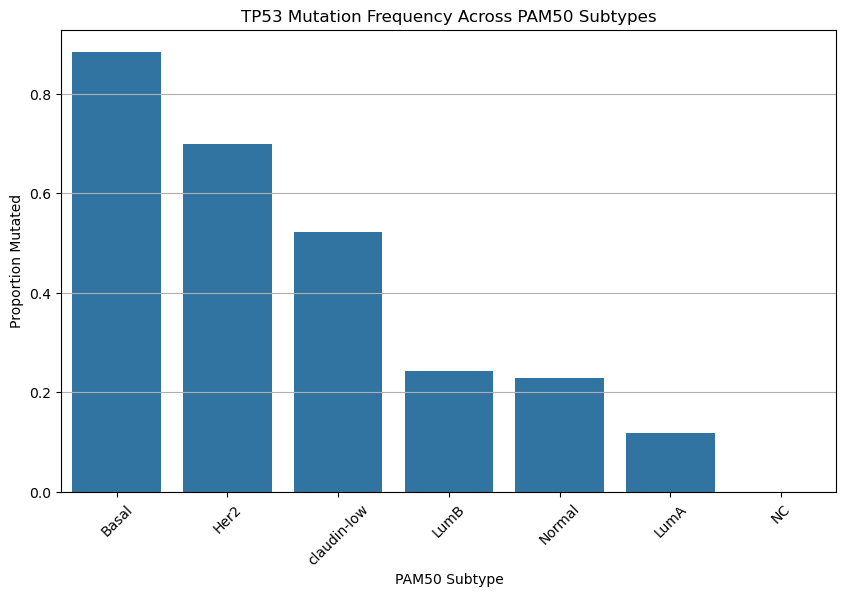

In [18]:
mutation = 'tp53_mut'

mutation_by_subtype = eda_df.groupby('pam50_+_claudin-low_subtype')[mutation].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=mutation_by_subtype.index, y=mutation_by_subtype.values)
plt.title('TP53 Mutation Frequency Across PAM50 Subtypes')
plt.ylabel('Proportion Mutated')
plt.xlabel('PAM50 Subtype')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Based on the chart above, do your best to answer the following questions: 

*Hint: TP53 mutations are often found in more **aggressive** cancers.*

**Question 2.1.** Which cancer subtype shows the highest frequency of TP53 mutation? Which shows the lowest?

*Type Your Answer Here*

**Question 2.2.** TP53 mutations are highly frequent in some breast cancer subtypes but almost absent in others. Why do you think TP53 mutations might be more common in certain subtypes? What does this suggest about the biology of these cancers?

*Type Your Answer Here*

**Question 2.3.** Based on the plot alone, can we conclude that if TP53 mutation exists, it causes a subtype to be more aggressive? Why or why not?

*Type Your Answer Here*

#### Histograms

Run the cell below. Please do not modify any of the lines—this cell has been pre-written to generate a specific visualization you’ll use to answer the following questions.

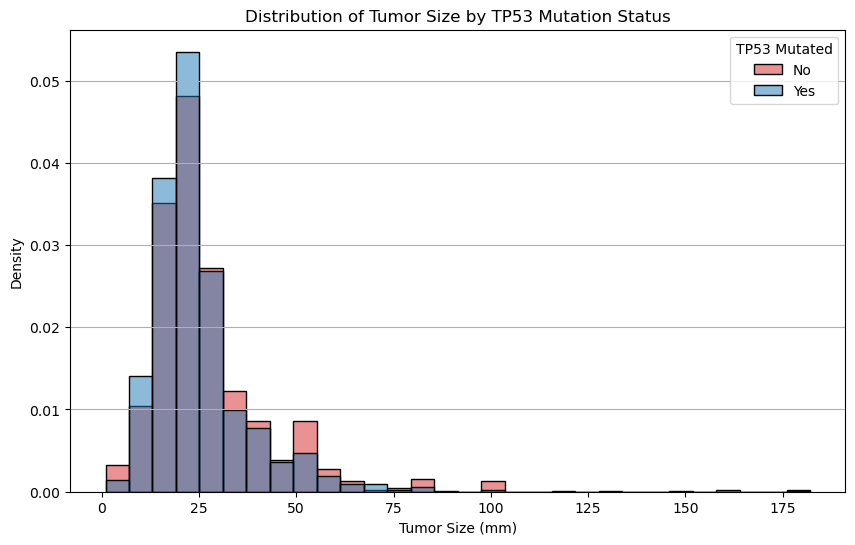

In [19]:
plt.figure(figsize=(10,6))
sns.histplot(data=eda_df, x='tumor_size', hue='tp53_mut', bins=30, palette=['#1f77b4', '#d62728'], stat='density', common_norm=False)
plt.title('Distribution of Tumor Size by TP53 Mutation Status')
plt.xlabel('Tumor Size (mm)')
plt.ylabel('Density')
plt.legend(title='TP53 Mutated', labels=['No', 'Yes'])
plt.grid(axis='y')
plt.show()

**Question 2.4.** Compare the shapes of the overlaid distributions. Among all patients *with* breast cancer, do patients with TP53 mutations tend to have larger tumors?

*Type Your Answer Here*

Run the cell below. Please do not modify any of the lines—this cell has been pre-written to generate a specific visualization you’ll use to answer the following questions.

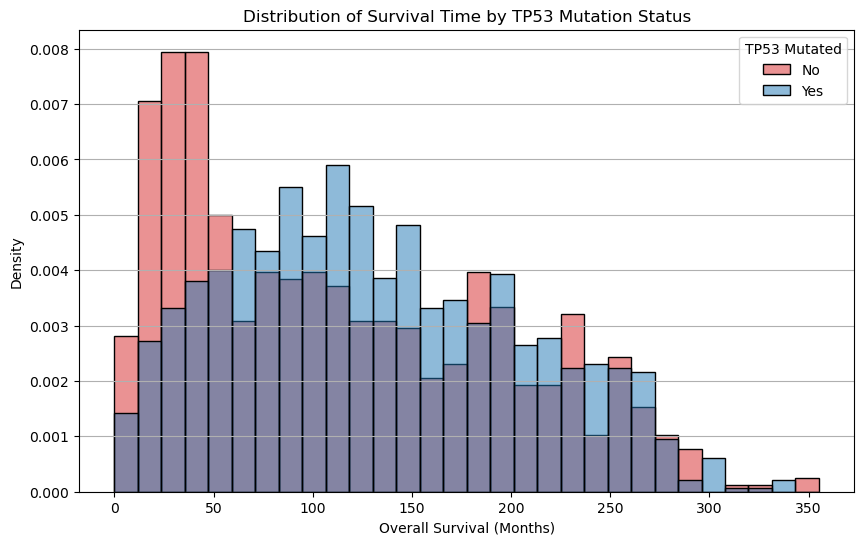

In [20]:
plt.figure(figsize=(10,6))
sns.histplot(data=eda_df, x='overall_survival_months', hue='tp53_mut', bins=30, palette=['#1f77b4', '#d62728'], stat='density', common_norm=False)
plt.title('Distribution of Survival Time by TP53 Mutation Status')
plt.xlabel('Overall Survival (Months)')
plt.ylabel('Density')
plt.legend(title='TP53 Mutated', labels=['No', 'Yes'])
plt.grid(axis='y')
plt.show()

**Question 2.5.** Which group seems to have longer average overall survival? Note key parts from the graph when writing your response.

*Type Your Answer Here*

#### Heat Map

The heatmap below displays the *proportion of patients* within each breast cancer subtype who carry a mutations in the various genes. This plot shows **how frequently** each gene is mutated **within each subtype**.  

- Each row corresponds to a gene (e.g., TP53, PIK3CA)

- Each column corresponds to a cancer subtypes (e.g., Basal, Luminal A)

- Each value in a particular cell corresponds to the proportion of patients **with that mutation, among those in the subtype**
  - For example: A value of `0.33` for **AKT1 in NC** means that **33% of NC-like patients** have an AKT1 mutation.

**Important Note:** These are **not correlations** between genes.  

Run the cell below. Please do not modify any of the lines—this cell has been pre-written to generate a specific visualization you’ll use to answer the following questions.

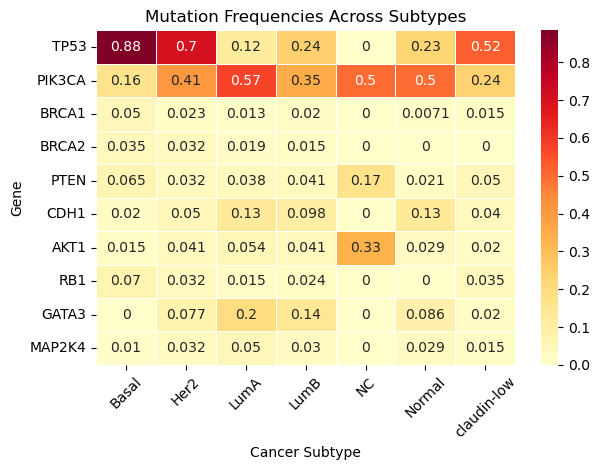

In [21]:
# List of mutation columns you want to include (binary: 0 = no mutation, 1 = mutated)
selected_mutations = [
    'tp53_mut', 'pik3ca_mut', 'brca1_mut', 'brca2_mut',
    'pten_mut', 'cdh1_mut', 'akt1_mut', 'rb1_mut',
    'gata3_mut', 'map2k4_mut'
]

# Group by cancer subtype and compute the mean (i.e. mutation rate) for each gene
mutation_subtype_matrix = eda_df.groupby('pam50_+_claudin-low_subtype')[selected_mutations].mean().T

# Optional: Make row labels cleaner
mutation_subtype_matrix.index = [gene.upper().replace('_MUT', '') for gene in mutation_subtype_matrix.index]

sns.heatmap(mutation_subtype_matrix, annot=True, cmap='YlOrRd', linewidths=0.5)
plt.title('Mutation Frequencies Across Subtypes')
plt.ylabel('Gene')
plt.xlabel('Cancer Subtype')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Question 2.6.** Which gene is mutated most often across all subtypes? Be sure to caculate the average mutaton frequency across all substypes when providing your answer.

*Type Your Answer Here*

**Question 2.7.** TP53 mutation is very common in Basal-like tumors but rare in Luminal A. Why could this be the case?

*Type Your Answer Here*

**Question 2.8.** Are there genes that are highly specific to one or two subtypes? Provide at least two examples.

*Type Your Answer Here*

**Question 2.9.** Are there genes that are rarely mutated in any subtype?

*Type Your Answer Here*

## Congratulations! 

Cookie 🍪 congratulates you on finishing the Cancer & Mutations notebook! 

<img src="cookie.png" style="width: 20%;">

In this notebook, we

- Explored cancer mutation data to uncover how specific gene mutations, such as TP53, BRCA1/2, and PIK3CA, vary across different cancer subtypes.

- Explored how these mutations might relate to tumor size and patient survival.

- Utilized visual tools like heatmaps and histograms, to identify patterns in mutation frequency, and began to connect genetic changes to clinical outcomes.

We hope you had fun learning throughout this notebook! If you're curious to explore some of these topics further, we encourage you to explore how statistical testing can be used to assess the significance of the patterns we observed. You might also try your hand at time-to-event models such as survival analysis, even incorporating clinical features such as treatment type or patient age. This is just the tip of the iceberg when it comes to the world of genomics! 

Below are some opportunities to explore further: 

- **El Camino College Research Club**: Participate in hands-on projects like DNA barcoding and species identification. Feel free to reach out to Professor McClelland to learn more! 

- [**Mathematics, Engineering, Science Achievement (MESA) Program**](https://www.elcamino.edu/support/resources/mesa/): Offers access to STEM internships, research opportunities, and academic support. 

- [**Honors Transfer Program (HTP)**](https://www.elcamino.edu/support/resources/honors-transfer/index.php): Engage in research projects and present findings at honors conferences!

- **Internships through the Life Sciences Department**: Opportunities such as the SEA Lab internship focus on marine biology, environmental studies, and conservation!

- **The [Lundquist Institute](https://lundquist.org/)**: Located near El Camino College, this institute offers programs where students can gain firsthand experience in scientific research environments.